<a href="https://colab.research.google.com/github/emily-pearl/Computational-Neuroscience/blob/main/Copy_of_load_ECoG_motor_imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Miller ECoG data of motor imagery



In [ ]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 26.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.

In [ ]:
from google.colab import files
from scipy import signal
from nilearn import plotting
from nimare import utils

In [ ]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #



This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper:

- Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697. doi: [10.1073/pnas.0913697107](https://doi.org/10.1073/pnas.0913697107)

<br>

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- ment was always contralateral to the side of cortical grid placement.*

<br>

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

<br>

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior.

Both experiments:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV).
* `dat['locs`]`: 3D electrode positions on the brain surface

In [ ]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat2['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

# Frequency Analysis

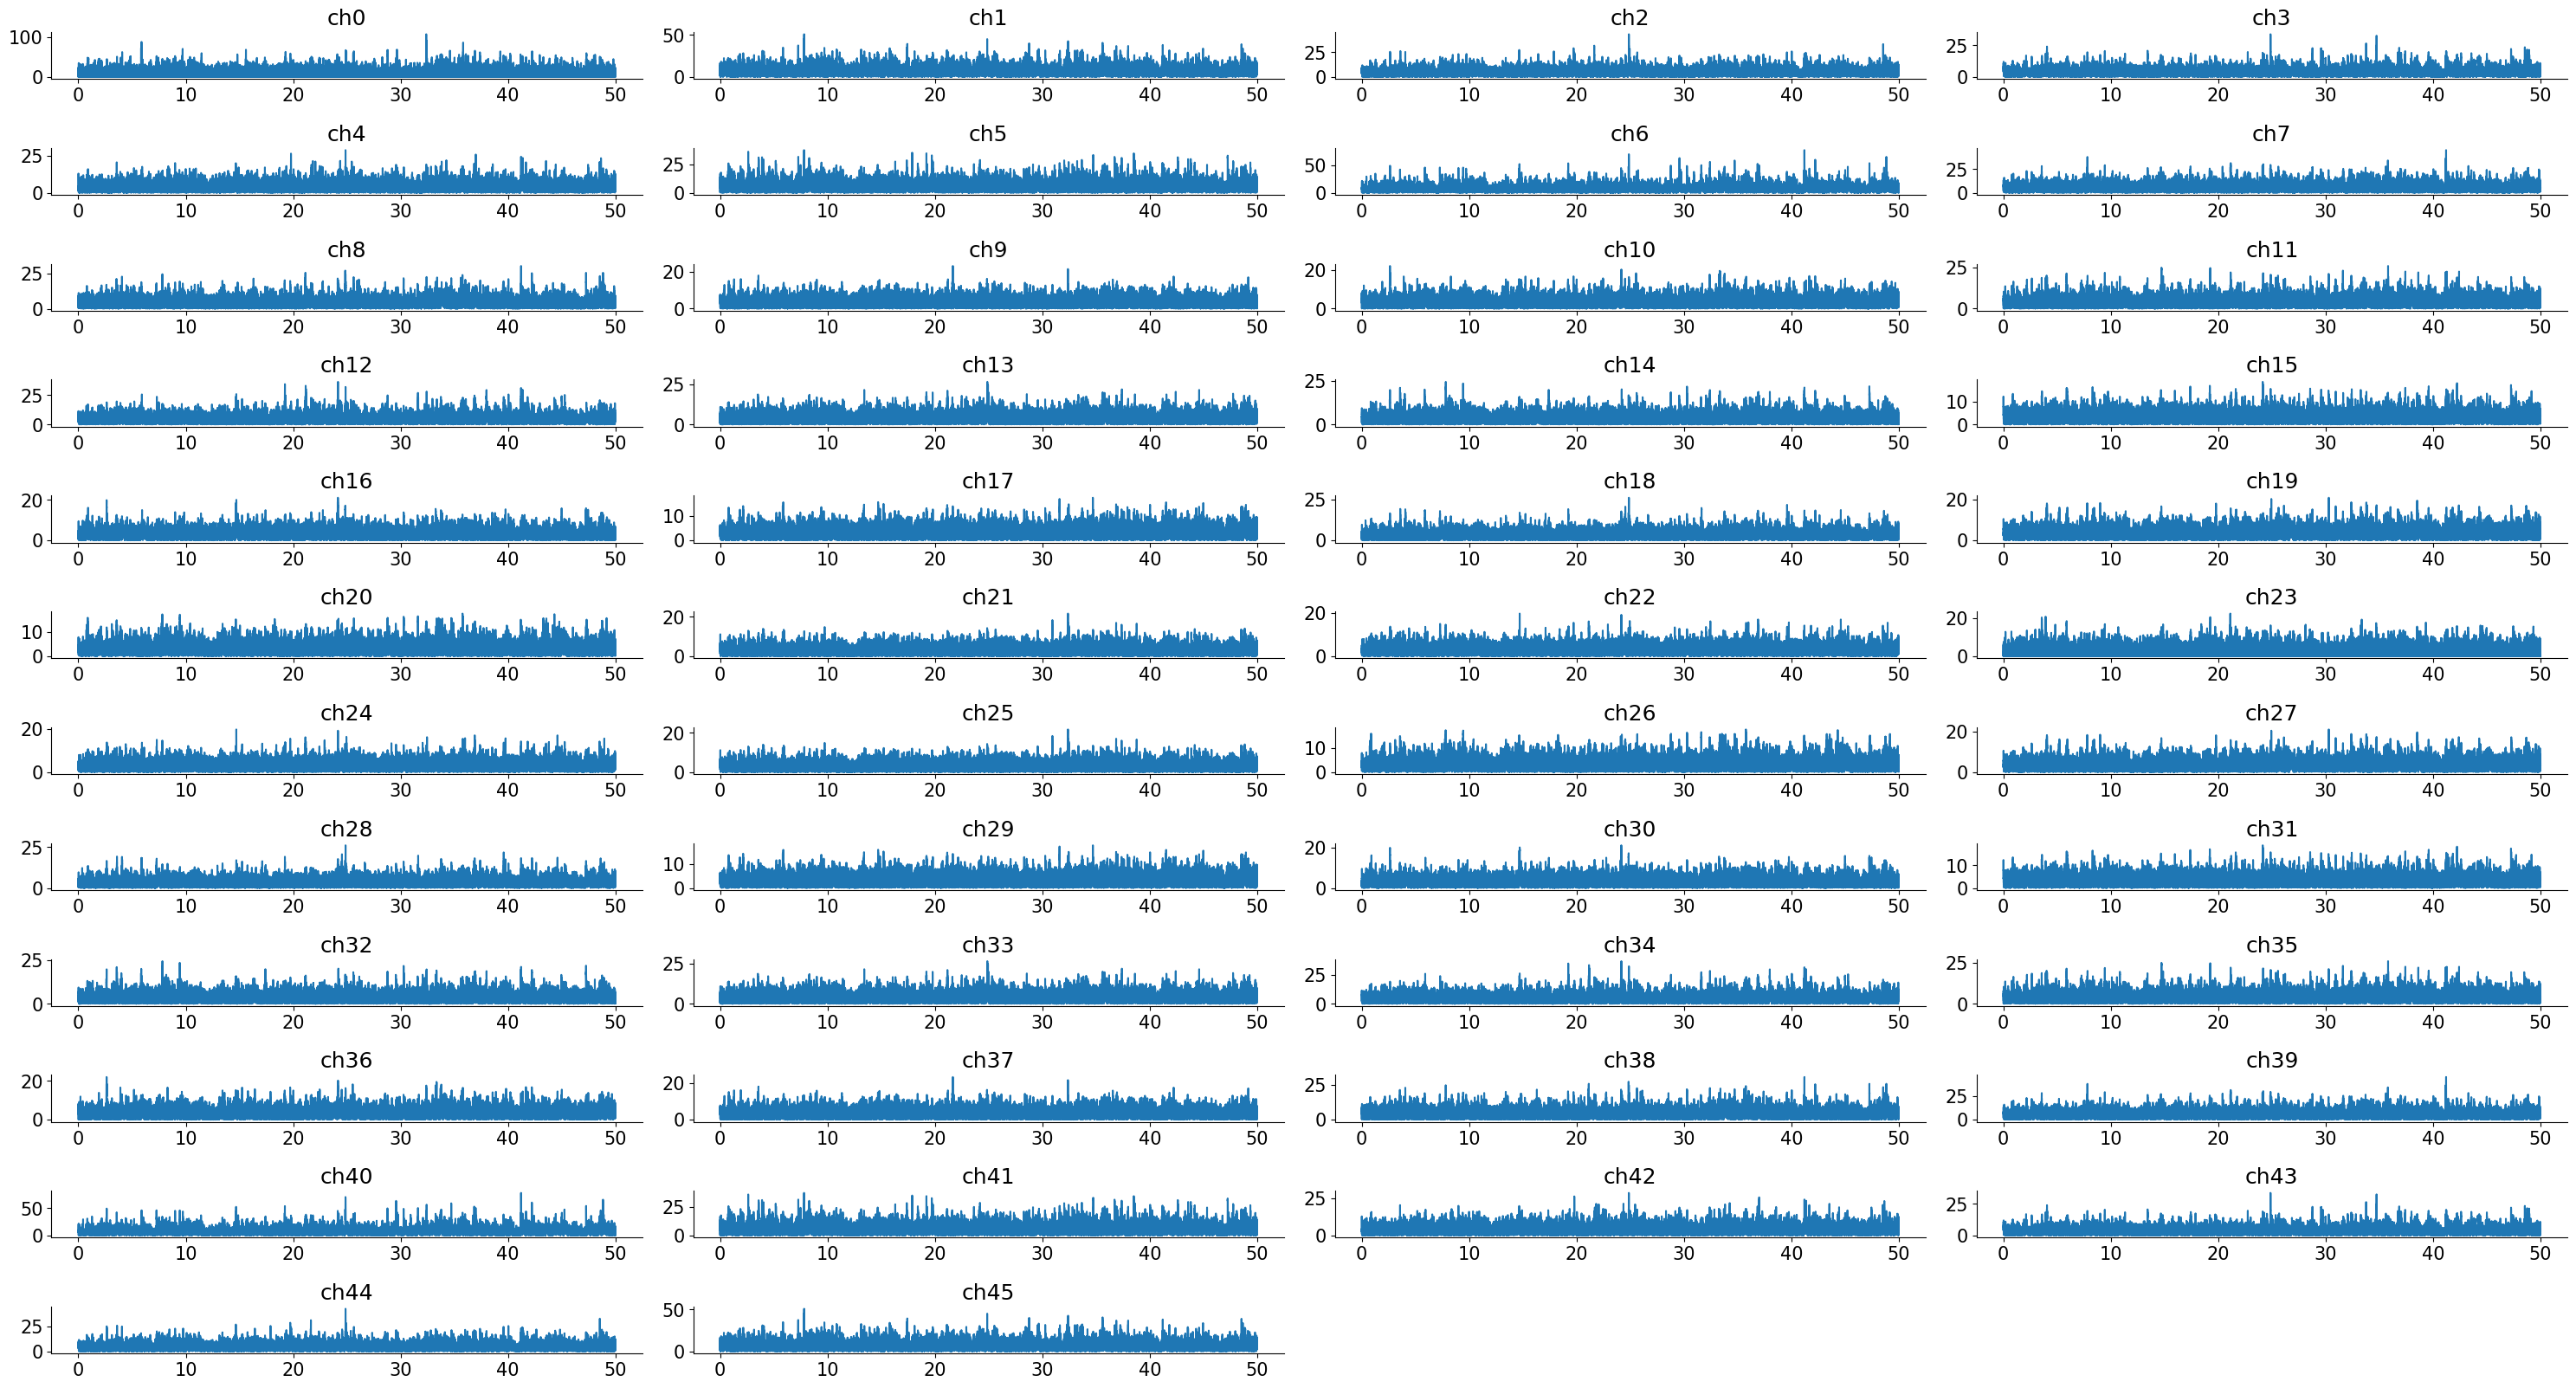

In [ ]:
#frequency analysis
import numpy as np


# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[0][1]

# V is the voltage data
V = dat1['V'].astype('float32')

# Compute the FFT of the signal using the fft() function
V_ft = np.fft.fft(V)

# Just keep magnitude
plt.magnitude_spectrum_V=np.abs(V_ft)

# Plot
plt.figure(figsize=(30, 20))
for j in range(46):
  ax = plt.subplot(15, 4, j+1)
  frequency=np.linspace(0,50,len(plt.magnitude_spectrum_V))
  plt.plot(frequency,plt.magnitude_spectrum_V[:,j])
  #ax.set_xlabel('Frequency')
  #ax.set_ylabel('Mag')
  plt.title('ch%d'%j)

plt.show()


# Pre-Analysis

In [ ]:
# quick way to get broadband power in time-varying windows

# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[2][0]

# V is the voltage data
V = dat1['V'].astype('float32')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

In [ ]:
V.shape

(376400, 46)

In [ ]:
dat1['t_on']

array([ 10160,  16160,  22160,  28240,  34240,  40320,  46360,  52440,
        58520,  64600,  70680,  76680,  82680,  88720,  94760, 100760,
       106800, 112840, 118880, 124960, 131040, 137080, 143160, 149160,
       155160, 161160, 167240, 173320, 179320, 185320, 191320, 197400,
       203400, 209480, 215520, 221520, 227560, 233600, 239640, 245640,
       251640, 257720, 263760, 269800, 275840, 281840, 287880, 293880,
       299880, 305920, 311920, 318000, 324000, 330080, 336120, 342200,
       348240, 354320, 360360, 366440])

In [ ]:
dat1['stim_id']

array([12, 12, 12, 11, 12, 12, 12, 11, 11, 12, 12, 11, 11, 11, 12, 11, 11,
       11, 12, 12, 11, 11, 12, 11, 11, 12, 12, 12, 11, 11, 12, 11, 12, 12,
       12, 12, 11, 12, 11, 12, 12, 11, 11, 12, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 11, 12, 11, 11, 12, 11, 11], dtype=int32)

In [ ]:
# average the broadband power across all tongue and hand trials
nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(0, 2000)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

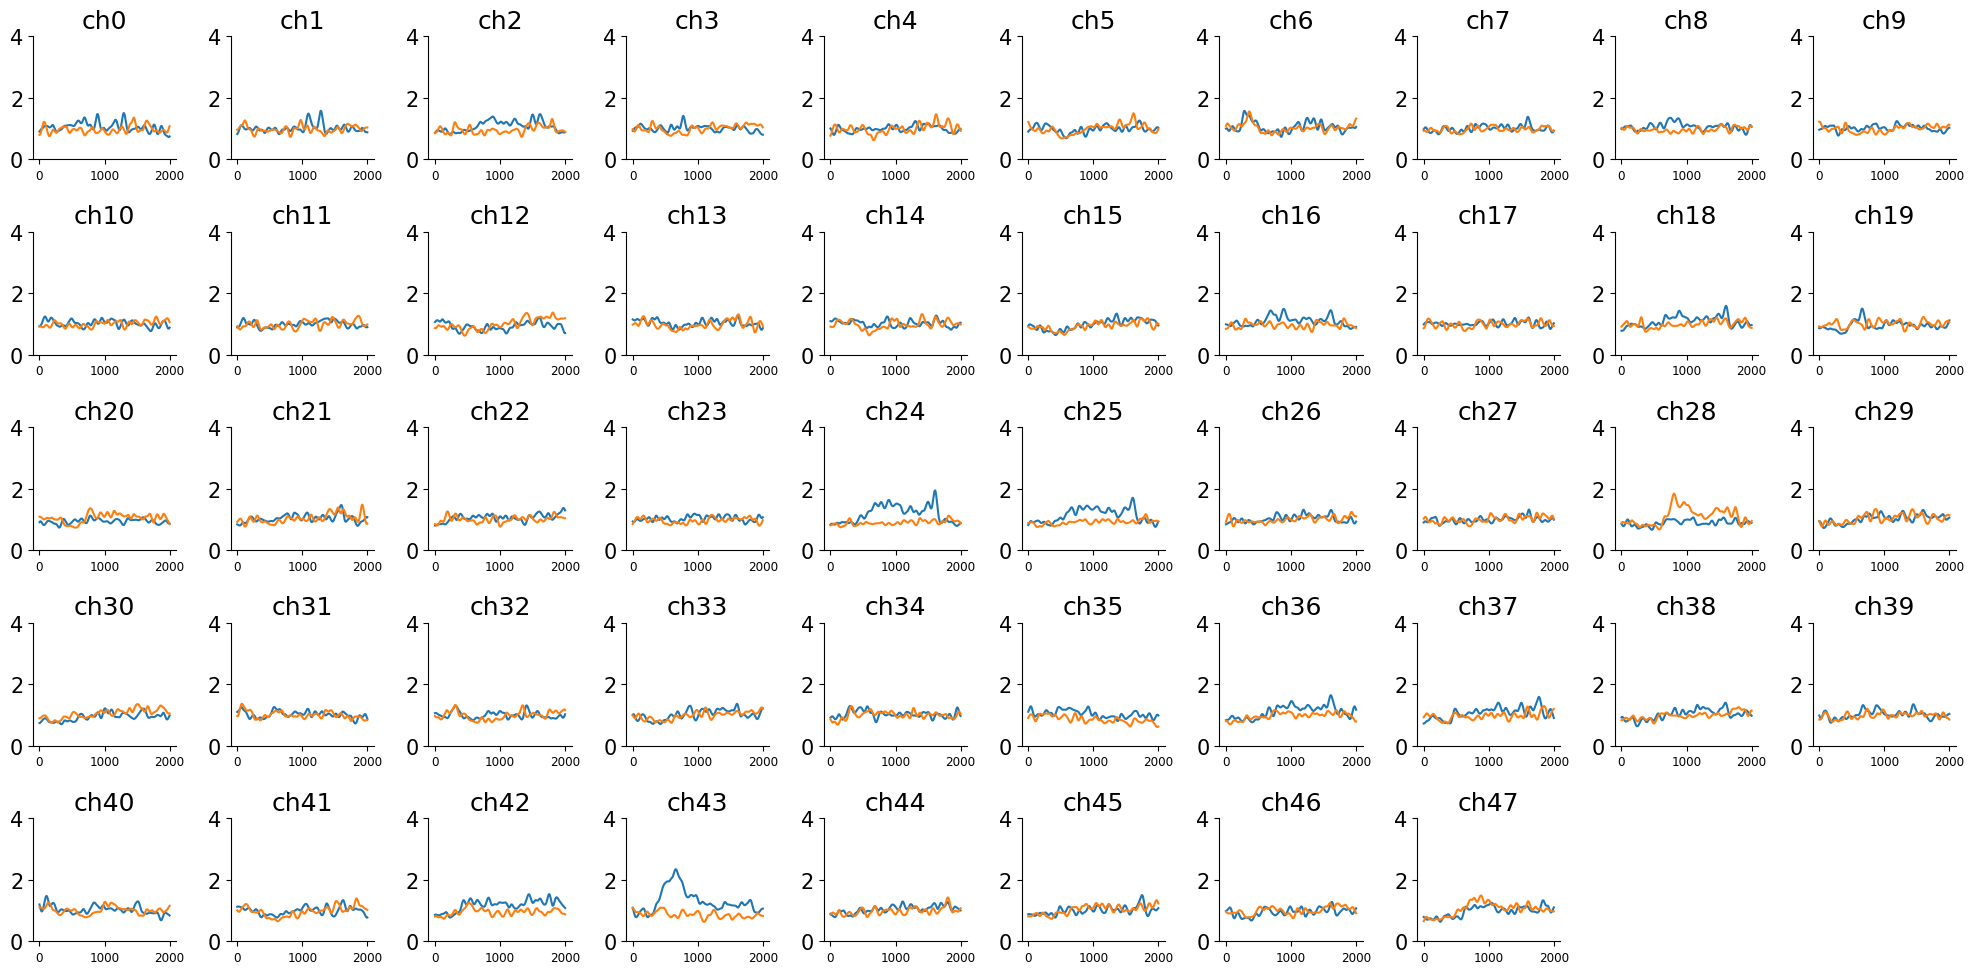

In [ ]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(V.shape[1]):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_tongue[:, j])
  plt.plot(trange, V_hand[:, j])
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000],fontsize = 'xx-small')
  plt.ylim([0, 4])
plt.show()

In [ ]:
V_epochs.shape

(60, 2000, 64)

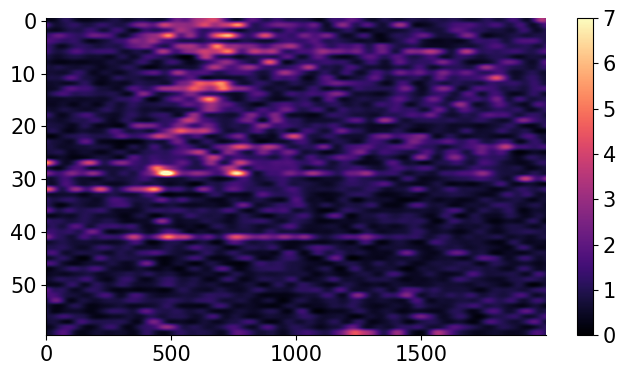

In [ ]:
# let's look at all the trials for electrode 20 that has a good response to hand movements
# we will sort trials by stimulus id
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 43].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

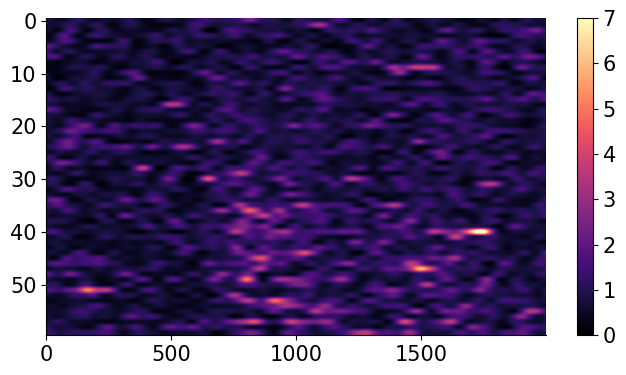

In [ ]:
# Electrode 42 seems to respond to tongue movements
isort = np.argsort(dat1['stim_id'])
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[isort, :, 28].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

# Function Definitions

In [ ]:
def pick_subj_exp(subject, experiment,return_v=True):

      if experiment == "imagery":
        experiment=1
      elif experiment == "real_mov":
        experiment = 0

      # pick subject 0 and experiment 0 (real movements)
      dat1 = alldat[subject][experiment]
      events =  dat1['t_on']
      stim_id = dat1['stim_id']
      V = 0
      if return_v:
        # V is the voltage data
        V = dat1['V'].astype('float32')

        # high-pass filter above 50 Hz
        b, a = signal.butter(3, [50], btype='high', fs=1000)
        V = signal.filtfilt(b, a, V, 0)

        # compute smooth envelope of this signal = approx power
        V = np.abs(V)**2
        b, a = signal.butter(3, [10], btype='low', fs=1000)
        V = signal.filtfilt(b, a, V, 0)

        # normalize each channel so its mean power is 1
        V = V/V.mean(0)

      return (V,events,stim_id)

In [ ]:
def cut_paste_data(event_type, channel, V, events, stim_id, offset_time):


  if event_type == "tongue":
    event_type = 11
  elif event_type == "hand":
    event_type = 12

  event_filter = (stim_id == event_type)  # seperate the events

  count=0
  events_of_interest = list()

  for x in event_filter:
    if(x):
      events_of_interest.append(events[count])
    count +=1

  clipped_ts= list()
  for event in events_of_interest:
    clipped_ts.append(V[event:event+offset_time,channel])

  clipped_ts=np.array(clipped_ts)
  clipped_ts=np.reshape(clipped_ts,(1,-1))
  return clipped_ts

In [ ]:
def make_corr_matrix(event_type,corr_electrodes, data):
  (V, events, stims) = data

  coeff_matrix=np.array(cut_paste_data(event_type, corr_electrodes[0], V, events, stims, 2000))

  for electrode in corr_electrodes[1:]:
    new_row= cut_paste_data(event_type, electrode, V, events, stims, 2000)
    coeff_matrix = np.vstack([coeff_matrix, new_row])

  return coeff_matrix


In [ ]:
def make_confussion_matrices(subject_num, body_part = "hand"):
  # real
  selected_data= pick_subj_exp(subject_num, "real_mov")              #args: subject, real or imagery
  electrodenum= selected_data[0].shape[1]
  corr_electrodes = range(electrodenum)
  coeff_matrix_r = make_corr_matrix(body_part, corr_electrodes, selected_data)   #np.abs
  correlations_real = np.corrcoef(coeff_matrix_r)

  # imagery
  selected_data= pick_subj_exp(subject_num, "imagery")              #args: subject, real or imagery
  electrodenum= selected_data[0].shape[1]
  corr_electrodes = range(electrodenum)
  coeff_matrix_i = make_corr_matrix(body_part,corr_electrodes, selected_data)   #np.abs
  correlations_img = np.corrcoef(coeff_matrix_i)

  #take difference
  correlations_diff = ((correlations_img)-(correlations_real))



  return (correlations_real,correlations_img,correlations_diff)


In [ ]:
def make_confussion_graphs(correlations_real,correlations_img,correlations_diff):
    #plot
  fig,axs = plt.subplots(1,3)

  axs[0].set_title("Real Motor Movement")
  axs[0].imshow(correlations_real.astype('float32'),
             aspect='auto')

  axs[1].set_title("Imagery Motor Movement")
  axs[1].imshow(correlations_img.astype('float32'),
             aspect='auto')

  axs[2].set_title("Difference Matrix")
  axs[2].imshow(correlations_diff.astype('float32'),
             aspect='auto', cmap = 'magma',vmax=np.max(correlations_diff)/2)


  #plt.colorbar()
  plt.show()


In [ ]:
def calculate_dissimilarity(real,img):
  temp_r = np.array([])
  temp_i = np.array([])
  for i in range(real.shape[0]):
    temp_r = np.append(temp_r,real[i,:i])
    temp_i = np.append(temp_i,img[i,:i])

  temp_i = np.reshape(temp_i, (1,-1))
  temp_r = np.reshape(temp_r, (1,-1))

  cc = np.corrcoef(temp_i,temp_r)
  return cc


In [ ]:
def rand_timeseries(V_r,real_times, V_i,img_times ,channel):
  # creates a random timeseries for on channel
  ts = list()
  r_i = np.random.randint(2,size=(30,1))
  t_h = np.random.randint(60,size=(30,1))
  aaa= np.hstack((r_i,t_h))
  for i in range(30):
    if aaa[i][0] == 0:
      ts.append(V_r[real_times[aaa[i][1]]:real_times[aaa[i][1]]+2000,channel])
    elif aaa[i][0] == 1:
      ts.append(V_i[img_times[aaa[i][1]]:img_times[aaa[i][1]]+2000,channel])

  clipped_ts=np.array(ts)
  clipped_ts=np.reshape(clipped_ts,(1,-1))
  return clipped_ts


# Correlations across channels

Correlations across channels

In [ ]:
subject_n = 2
dat2 = alldat[subject_n][0]
plt.figure(figsize=(8, 8))
locs = dat2['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                           marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                           marker_color='purple',
                           marker_size=5)
view

<Figure size 800x800 with 0 Axes>

Confussion matrices for real and imagery motor movements (participant = 0)

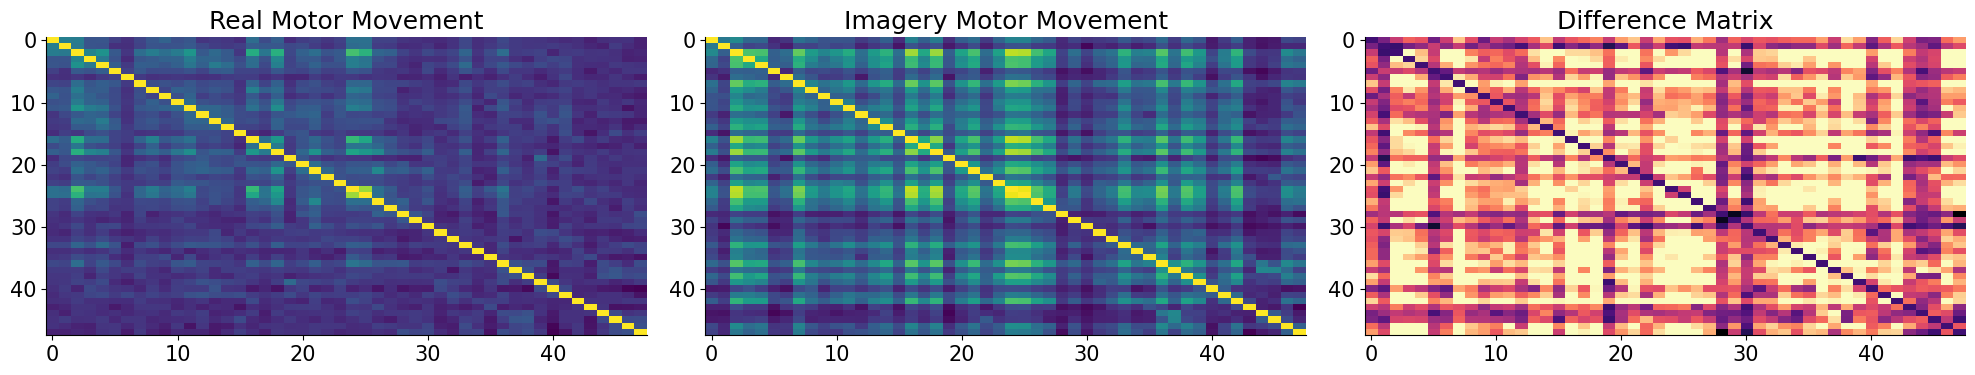

In [ ]:
(rr,iim,ddd) = make_confussion_matrices(subject_n)   #arg: subject number
make_confussion_graphs(rr,iim,ddd)

This is the confussion matrix for real hand movements of participant 0

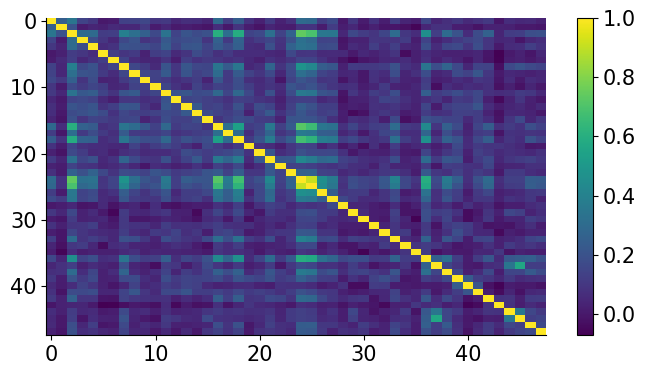

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(rr.astype('float32'),
           aspect='auto')
plt.colorbar()
plt.show()

Connectivity matrix of electrode 25 WRT other channels

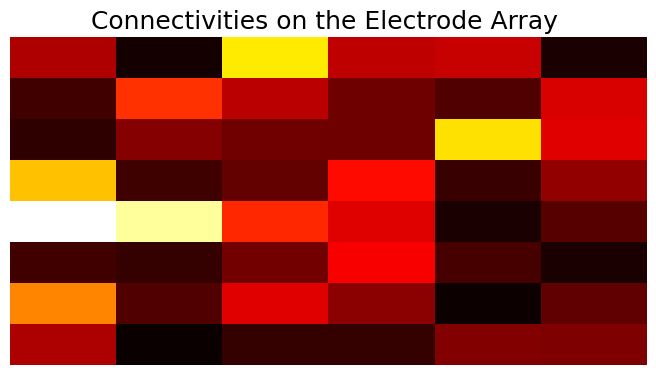

In [ ]:
from matplotlib.projections import axes
plt.subplot(1, 3, 1)
plt.imshow(np.append(rr[24],[]).reshape((8,-1)).astype('float32'),
           aspect='auto',interpolation='nearest', cmap='hot')
plt.axis('off')
plt.title('Connectivities on the Electrode Array ')
plt.show()

Total connectivity pattern for all channels performing real motor movement

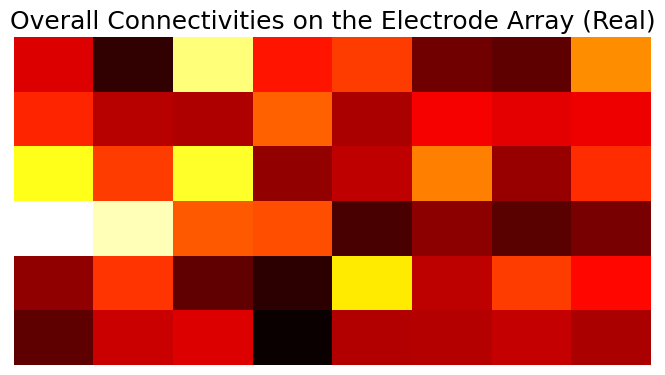

In [ ]:
ff = np.zeros((6,8))
for i in range(rr.shape[0]):
  ff= ff+ np.append(rr[i],[]).reshape((6,-1))

from matplotlib.projections import axes
plt.subplot(1, 3, 1)
plt.imshow(ff.astype('float32'),
           aspect='auto',interpolation='nearest', cmap='hot')
plt.axis('off')
plt.title('Overall Connectivities on the Electrode Array (Real)')
plt.show()



In [ ]:
a = np.flip(np.argsort(ff.reshape(-1)))
print("Most Connected Electrodes in Real Movements\n")
for i in range(25):
  print(a[i],"th Electrode = ",alldat[subject_n][0]['Brodmann_Area'][a[i]])


Most Connected Electrodes in Real Movements

24 th Electrode =  Brodmann area 45
25 th Electrode =  Brodmann area 44
2 th Electrode =  Brodmann area 21
18 th Electrode =  Brodmann area 22
16 th Electrode =  Brodmann area 47
36 th Electrode =  Brodmann area 4
7 th Electrode =  Brodmann area 21
21 th Electrode =  Brodmann area 42
11 th Electrode =  Brodmann area 21
26 th Electrode =  Brodmann area 6
27 th Electrode =  Brodmann area 43
4 th Electrode =  Brodmann area 21
38 th Electrode =  Brodmann area 40
17 th Electrode =  Brodmann area 22
33 th Electrode =  Brodmann area 45
23 th Electrode =  Brodmann area 22
8 th Electrode =  Brodmann area 38
3 th Electrode =  Brodmann area 21
39 th Electrode =  Brodmann area 40
13 th Electrode =  Brodmann area 21
15 th Electrode =  Brodmann area 22
14 th Electrode =  Brodmann area 22
42 th Electrode =  Brodmann area 9
0 th Electrode =  Brodmann area 38
41 th Electrode =  Brodmann area 45


Total connectivity pattern for all channels performing imagery motor movement

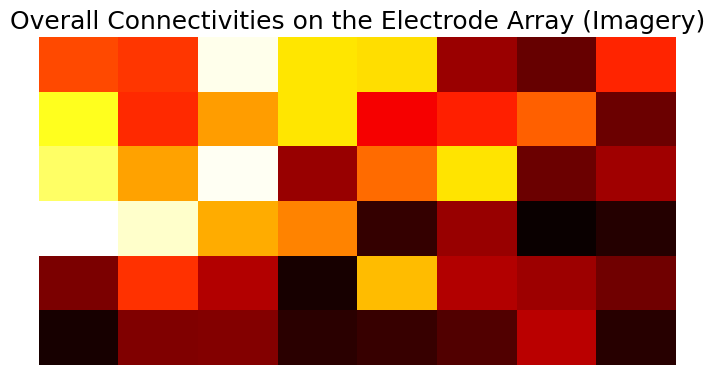

In [ ]:
ff = np.zeros((6,8))
for i in range(rr.shape[0]):
  ff= ff+ np.append(iim[i],[]).reshape((6,-1))

from matplotlib.projections import axes
plt.subplot(1, 3, 1)
plt.imshow(ff.astype('float32'),
           aspect='auto',interpolation='nearest', cmap='hot')
plt.axis('off')
plt.title('Overall Connectivities on the Electrode Array (Imagery)')
plt.show()

In [ ]:
a = np.flip(np.argsort(ff.reshape(-1)))
print("Most Connected Electrodes in Imagery Movements\n")
for i in range(25):
  print(a[i],"th Electrode = ",alldat[subject_n][1]['Brodmann_Area'][a[i]])


Most Connected Electrodes in Imagery Movements

24 th Electrode =  Brodmann area 45
18 th Electrode =  Brodmann area 22
2 th Electrode =  Brodmann area 21
25 th Electrode =  Brodmann area 44
16 th Electrode =  Brodmann area 47
8 th Electrode =  Brodmann area 38
3 th Electrode =  Brodmann area 21
11 th Electrode =  Brodmann area 21
21 th Electrode =  Brodmann area 42
4 th Electrode =  Brodmann area 21
36 th Electrode =  Brodmann area 4
26 th Electrode =  Brodmann area 6
17 th Electrode =  Brodmann area 22
10 th Electrode =  Brodmann area 21
27 th Electrode =  Brodmann area 43
20 th Electrode =  Brodmann area 42
14 th Electrode =  Brodmann area 22
0 th Electrode =  Brodmann area 38
1 th Electrode =  Brodmann area 21
33 th Electrode =  Brodmann area 45
9 th Electrode =  Brodmann area 21
7 th Electrode =  Brodmann area 21
13 th Electrode =  Brodmann area 21
12 th Electrode =  Brodmann area 21
46 th Electrode =  Brodmann area 2


In [ ]:
alldat[5][0]['Brodmann_Area'][35]

'Brodmann area 6'

Difference of them

In [ ]:
ff = np.zeros((8,8))
for i in range(rr.shape[0]):
  ff= ff+ np.append(iim[i]-rr[i],[]).reshape((8,-1))

from matplotlib.projections import axes
plt.subplot(1, 3, 1)
plt.imshow(ff.astype('float32'),
           aspect='auto',interpolation='nearest', cmap='hot')
plt.axis('off')
plt.title('How Connectivities Diferred Between Imagery and Real Movement on the Electrode Array')
plt.show()

ValueError: ignored

What is the maximum value in the difference matrix



In [ ]:
np.max(ddd)

0.2854935028175562

Subjects and the respective electrode numbers

In [ ]:
for i in range(7):
  (V,_,_)  = pick_subj_exp(i, "real_mov")
  print("Subject", i, "has", V.shape[1], "electrodes")

Subject 0 has 46 electrodes
Subject 1 has 64 electrodes
Subject 2 has 48 electrodes
Subject 3 has 48 electrodes
Subject 4 has 64 electrodes
Subject 5 has 64 electrodes
Subject 6 has 64 electrodes


Connectivity matrices for first 3 participants. Since 2nd participant's electrodes are poorly referenced, the recorded response from each channel seems the same without any preprocessing, resulting a confussion matrix with elements very close to 1.

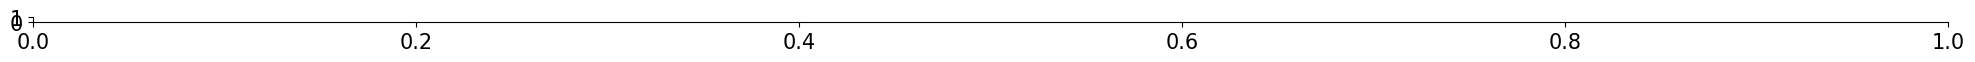

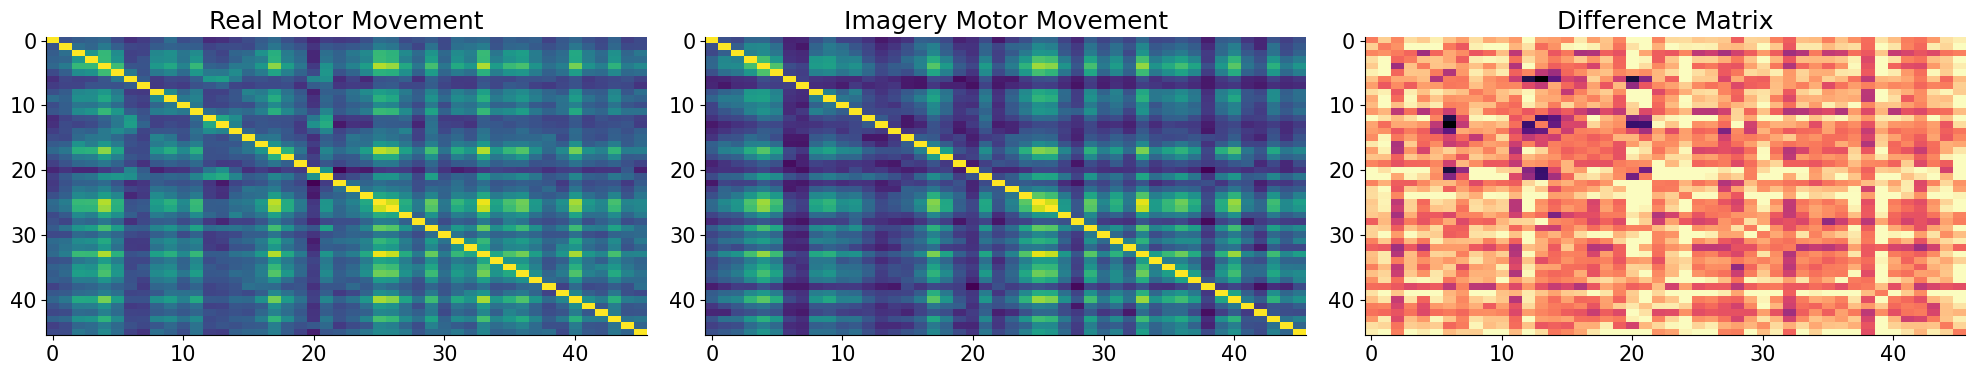

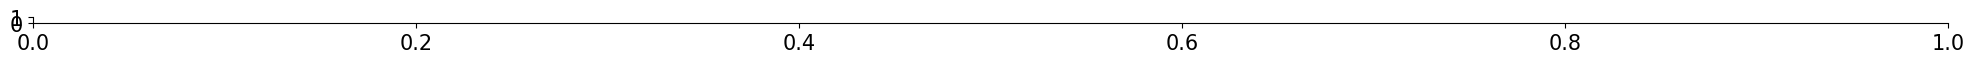

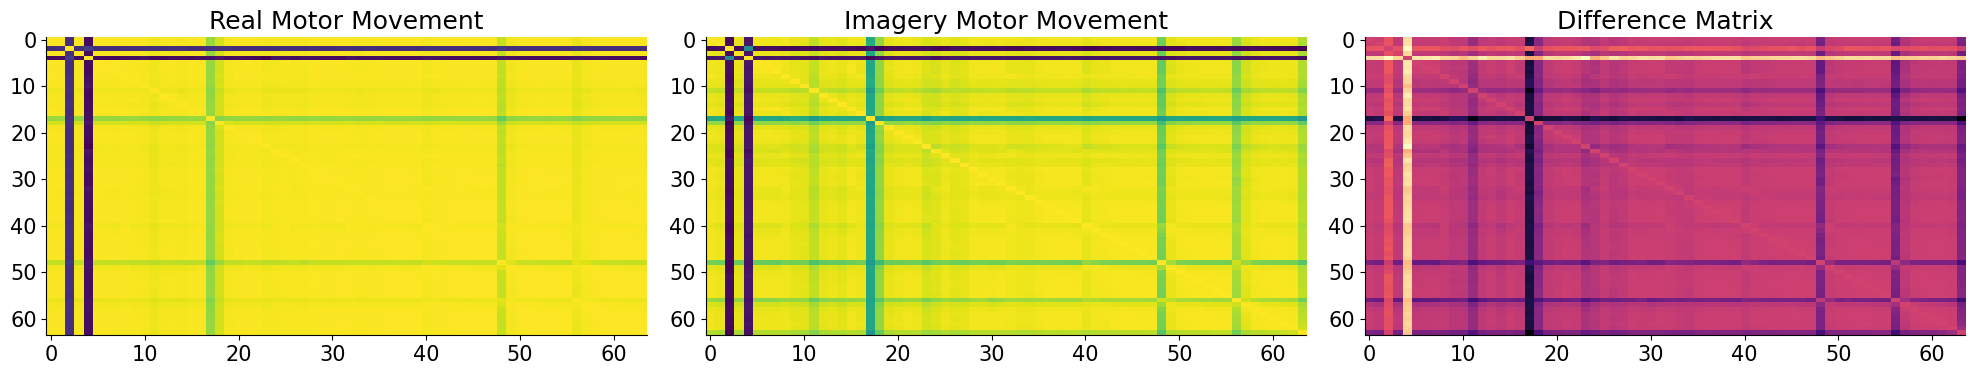

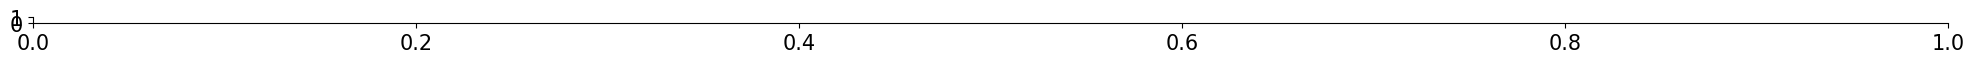

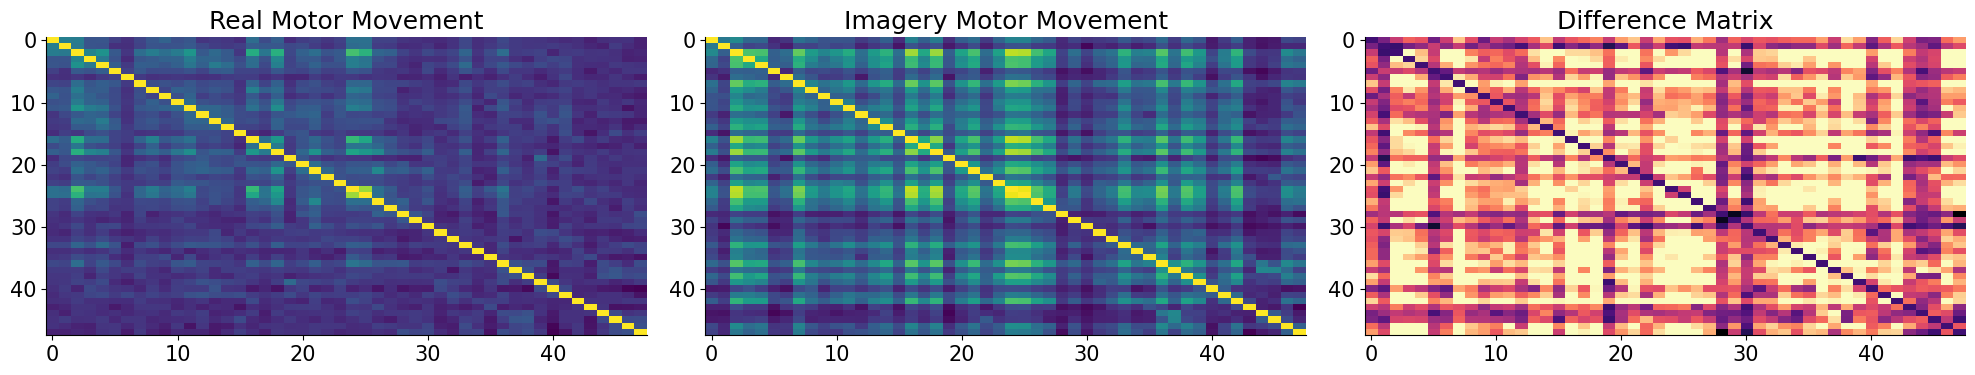

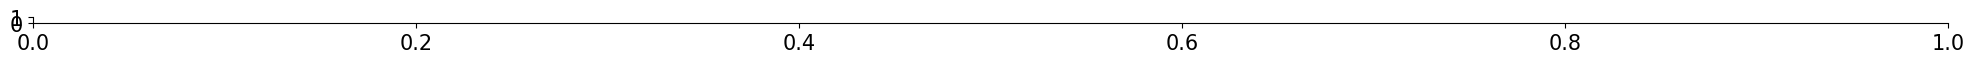

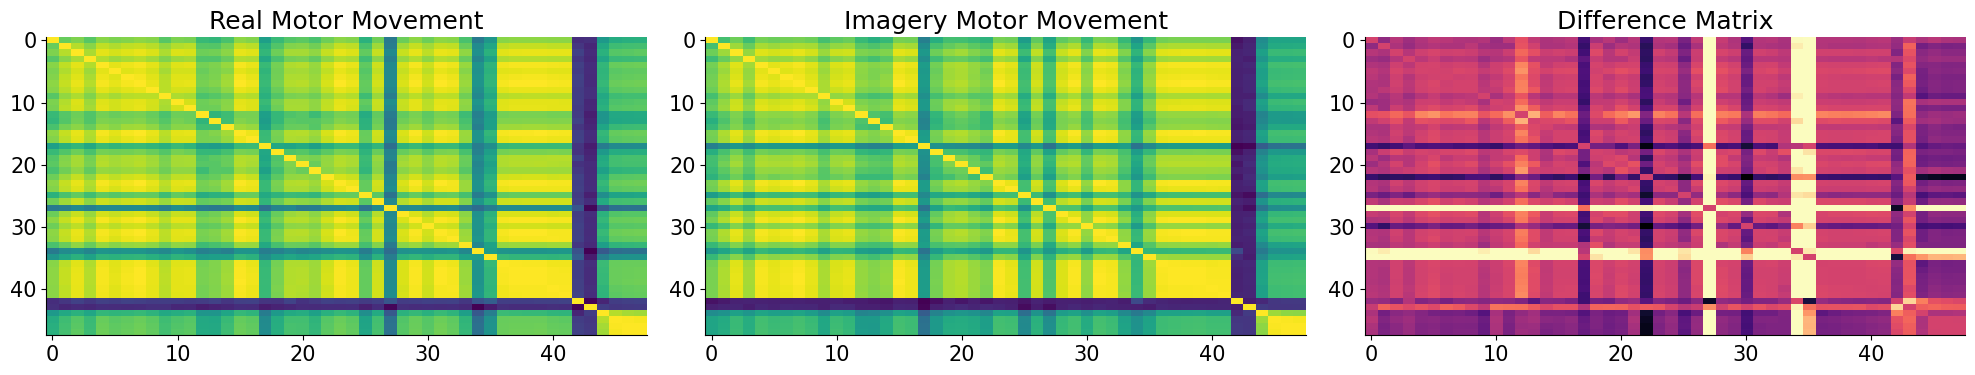

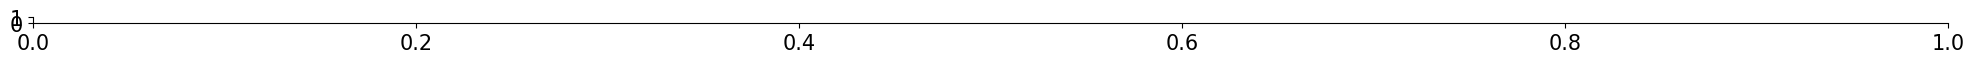

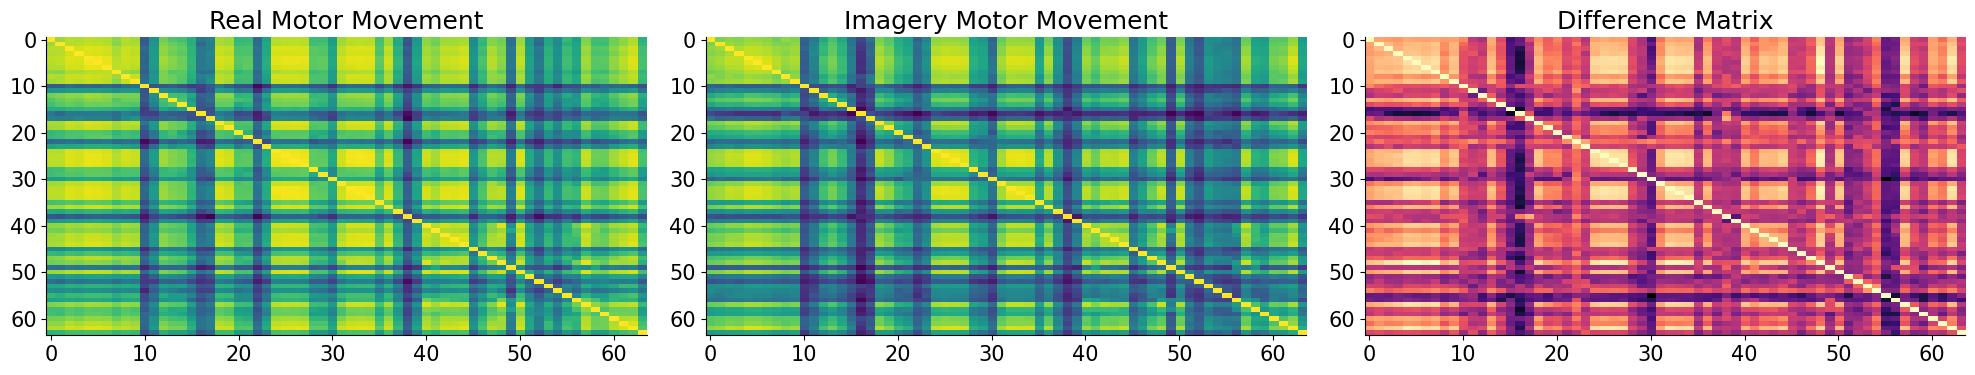

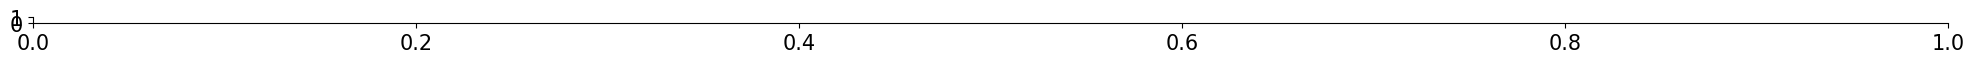

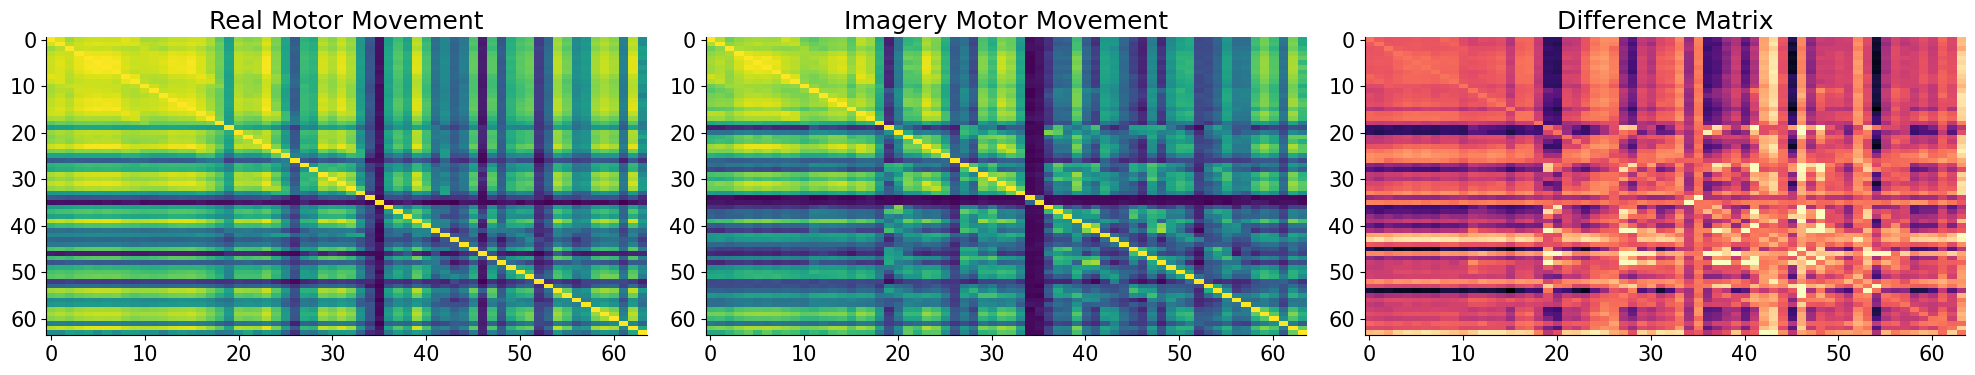

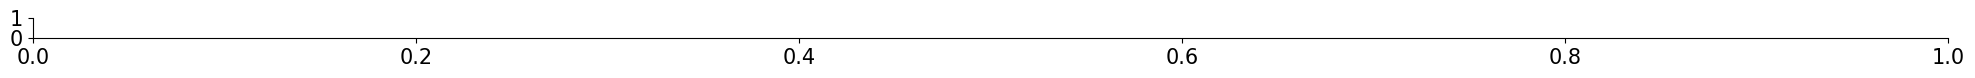

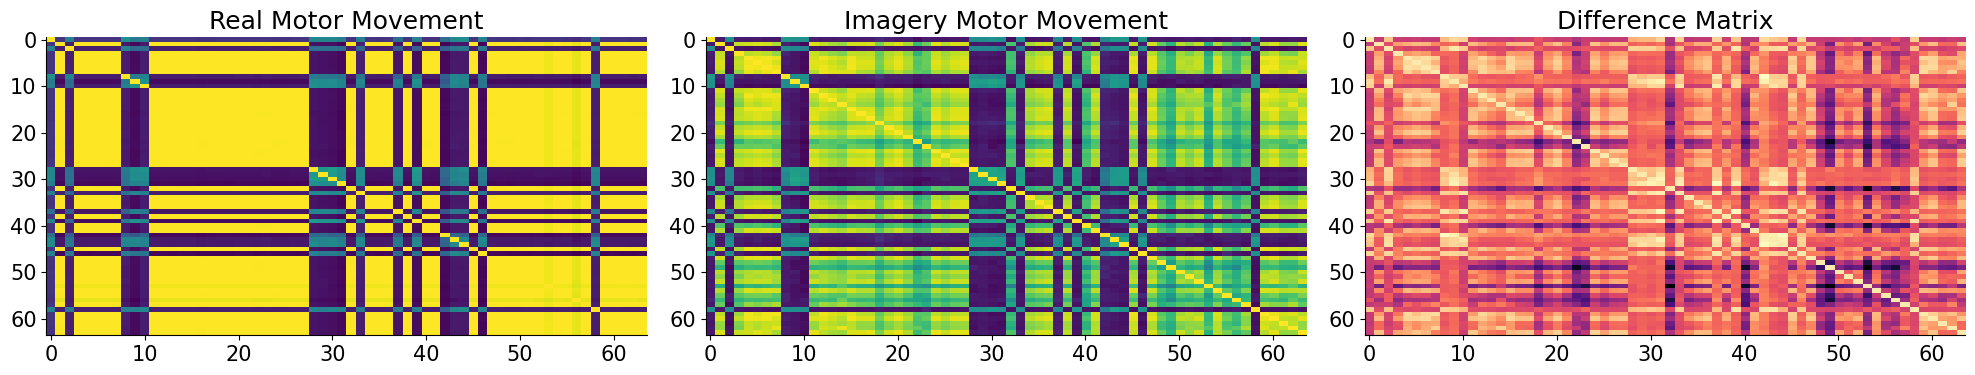

In [ ]:
plt.figure()
for i in range(7):
  ax = plt.subplot(7, 1, i+1)
  (rr,iim,ddd) = make_confussion_matrices(i)   #arg: subject number
  make_confussion_graphs(rr,iim,ddd)
plt.show()


Calculate Dissimilarities

dissimilarity = 1 - correlation

In [ ]:
rr = calculate_dissimilarity(rr,iim)[0][1]
dissimilarity = 1-rr

In [ ]:
dissimilarity

0.3499845746137418

Lets now calculate dissimilarities across different subjects for tongue movements

In [ ]:
dissimilarities_tongue = list()
for i in range(7):
  (real,im,d) = make_confussion_matrices(i,body_part="tongue")
  rr = calculate_dissimilarity(real,im)[0][1]
  dissimilarity = 1-rr
  dissimilarities_tongue.append(dissimilarity)
print(dissimilarities_tongue)

[0.2304702885006794, 0.04173960692915979, 0.23434078773063882, 0.02931238686879789, 0.29263528032370256, 0.09793071621482385, 0.049806418664287144]


For hand movements

In [ ]:
dissimilarities_hand = list()
for i in range(7):
  (real,im,d) = make_confussion_matrices(i,body_part="hand")
  rr = calculate_dissimilarity(real,im)[0][1]
  dissimilarity = 1-rr
  dissimilarities_hand.append(dissimilarity)
print(dissimilarities_tongue)

[0.2304702885006794, 0.04173960692915979, 0.23434078773063882, 0.02931238686879789, 0.29263528032370256, 0.09793071621482385, 0.049806418664287144]


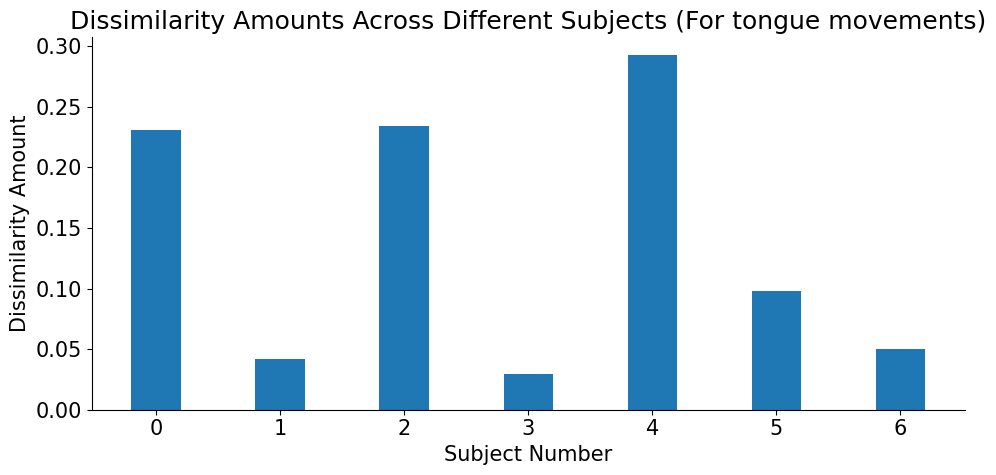

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(range(7), dissimilarities_tongue,
        width = 0.4)

plt.xlabel("Subject Number")
plt.ylabel("Dissimilarity Amount")
plt.title("Dissimilarity Amounts Across Different Subjects (For tongue movements)")
plt.show()


# Correlations between different time offsets



In order to detect temporal connectivities, different time offsets are tried and checked for connectivity for each of them, thinking highest correlation will emerge at correct offset time.


<br><br>Correlations between different time offsets for a specific channel (here 20)

In [ ]:
times = np.linspace(-1000,1000,150).astype(int)
selected_data= pick_subj_exp(0, "real_mov")              #args: subject, real or imagery
(V, events, stims) = selected_data
electrodenum= V.shape[1]
ts1 = cut_paste_data("hand", 4, V, events, stims, 2000)

corrs = list()
for i in range(electrodenum):
  corrs.append([])
  for time in times:
    ts = cut_paste_data("hand",i , V, events+time, stims, 2000)
    corrs[i].append(np.corrcoef(ts1,ts)[0][1])

corrs = np.array(corrs)

In [ ]:
corrs.shape

(46, 150)

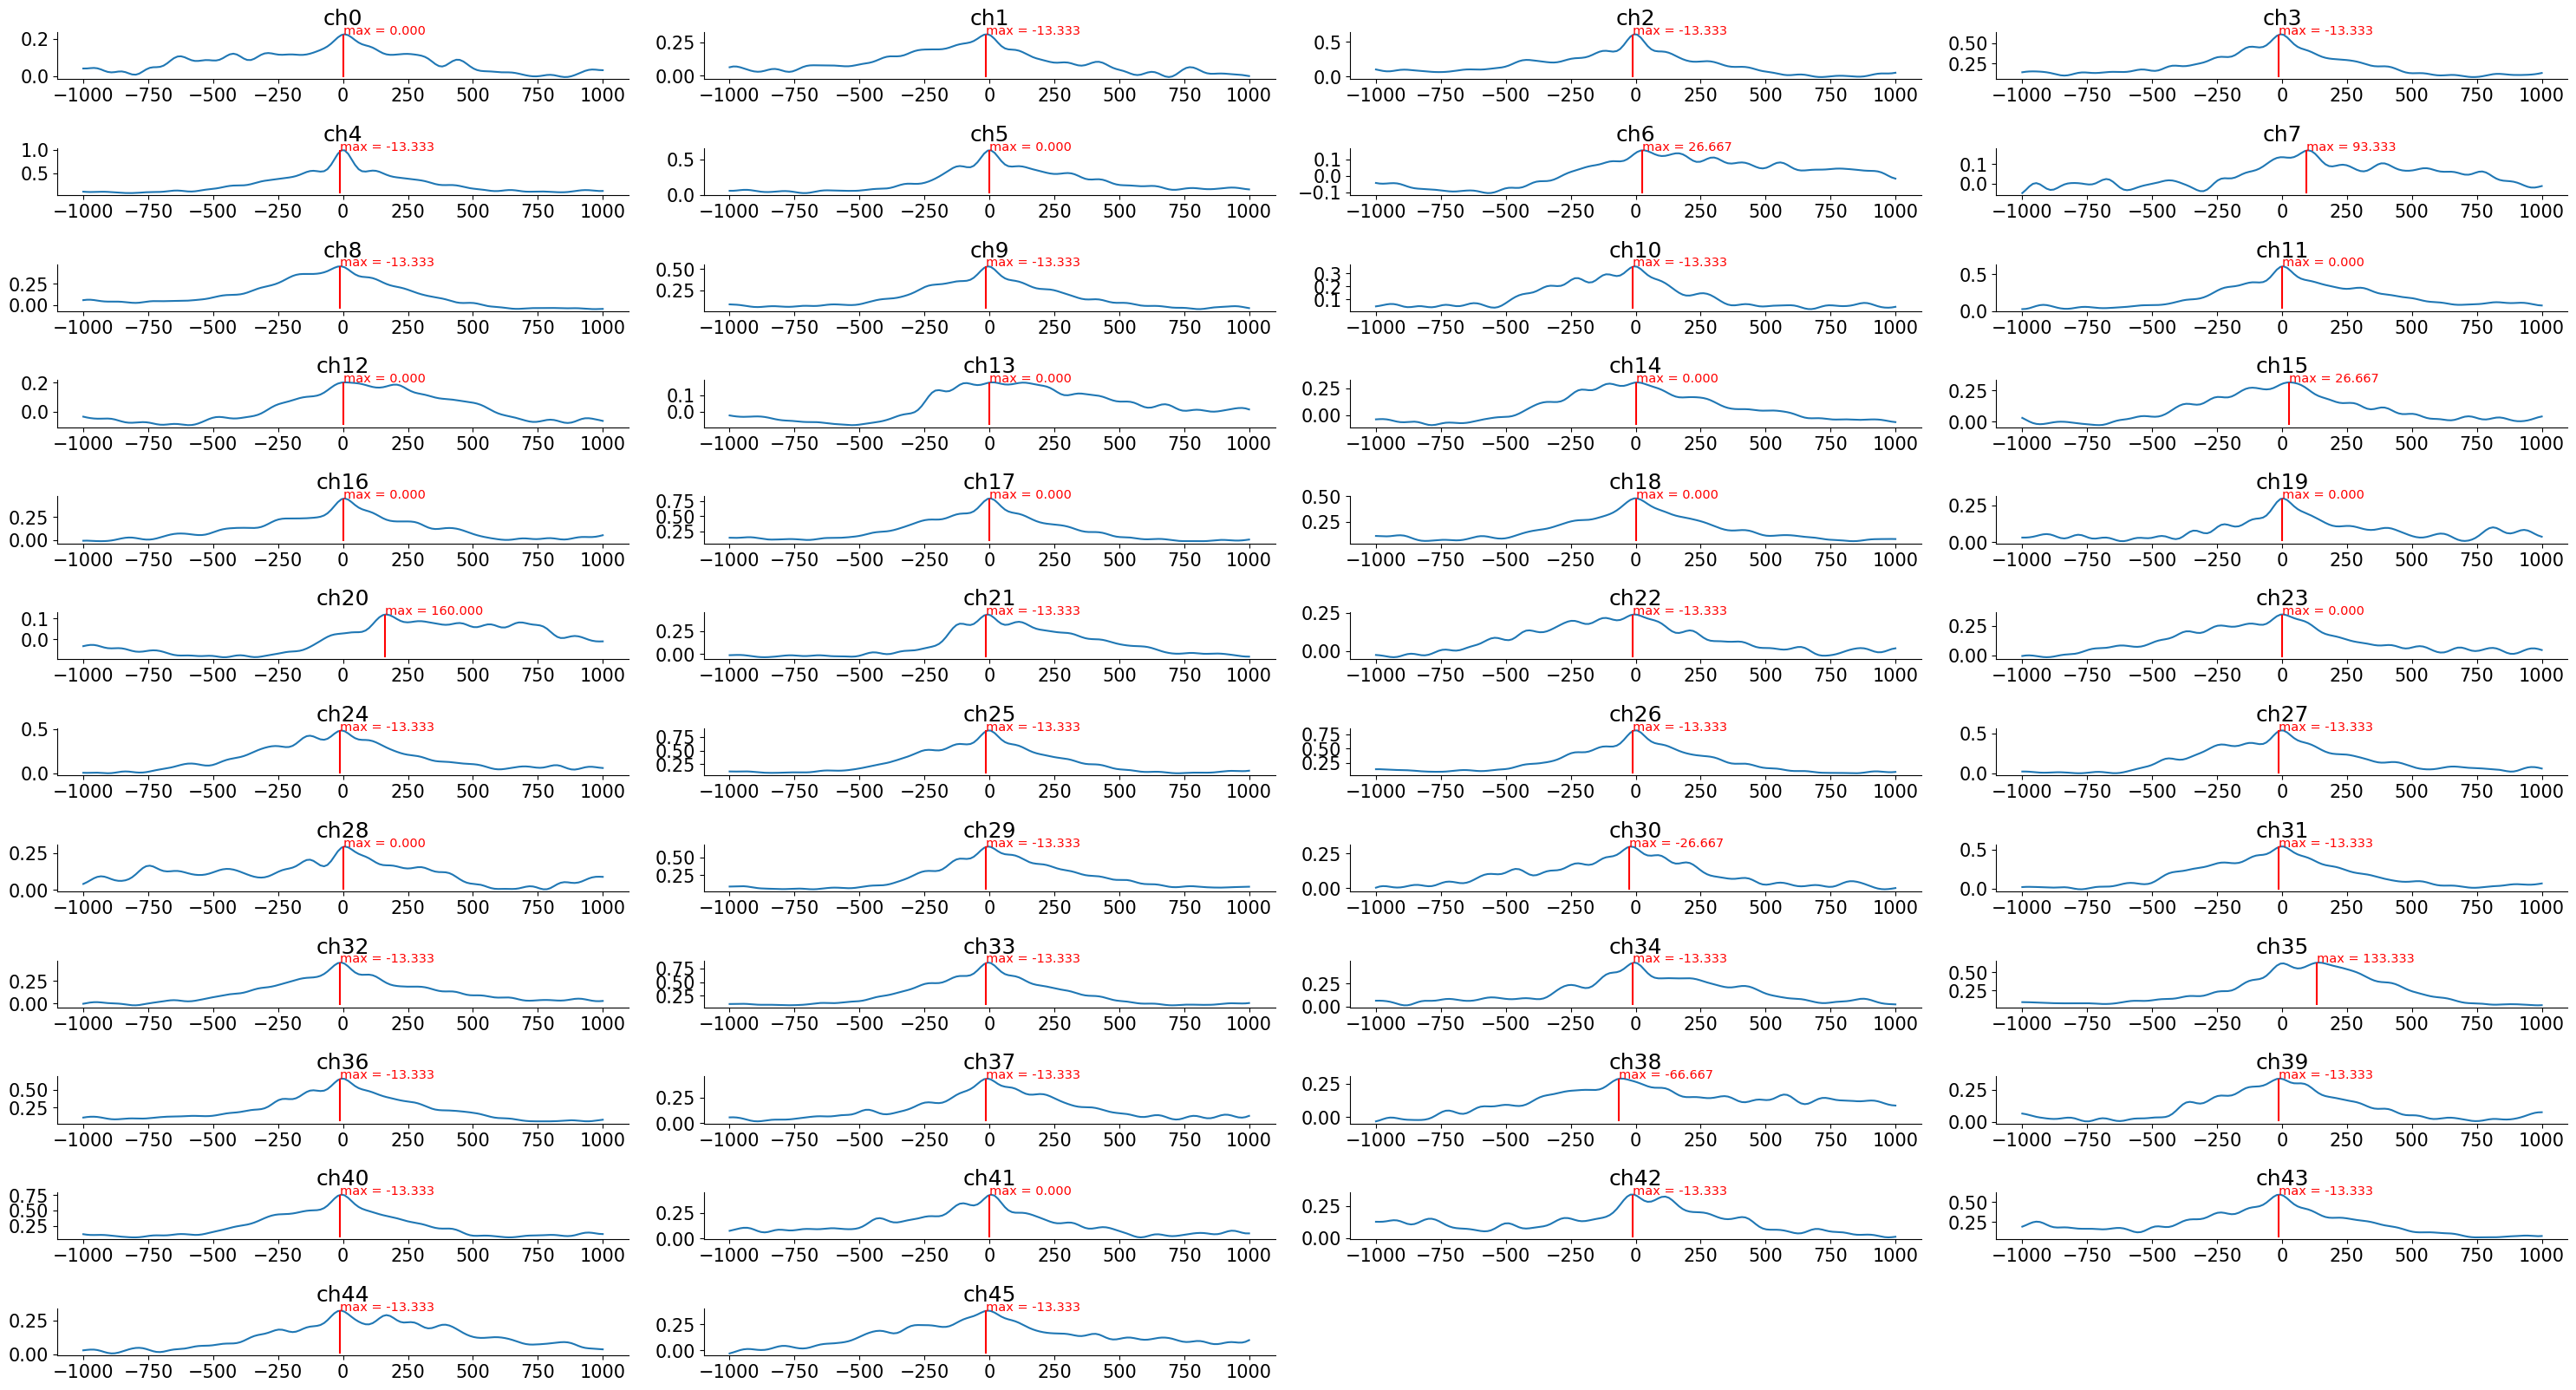

In [ ]:
plt.figure(figsize=(30, 20))
for j in range(electrodenum):
  ax = plt.subplot(15, 4, j+1)
  plt.plot(times,corrs[j])
  max_loc = np.argmax(corrs[j])*2000/150-1000
  plt.vlines(max_loc,np.min(corrs[j]),np.max(corrs[j]),colors ='r',label= 'mean')
  plt.text(max_loc,np.max(corrs[j]),f'max = {max_loc:.3f}',fontsize='x-small',color ='r')
  # ax.set_xlabel('Offset')
  # ax.set_ylabel('Correlation')
  plt.title('ch%d'%j)

plt.show()


# Now try to compare dissimilarities with randomness

In [ ]:
V_r,re,_ = pick_subj_exp(4,"real_mov")
V_i,img,_ = pick_subj_exp(4,"imagery")


Confussion matrix made from random permutation of events

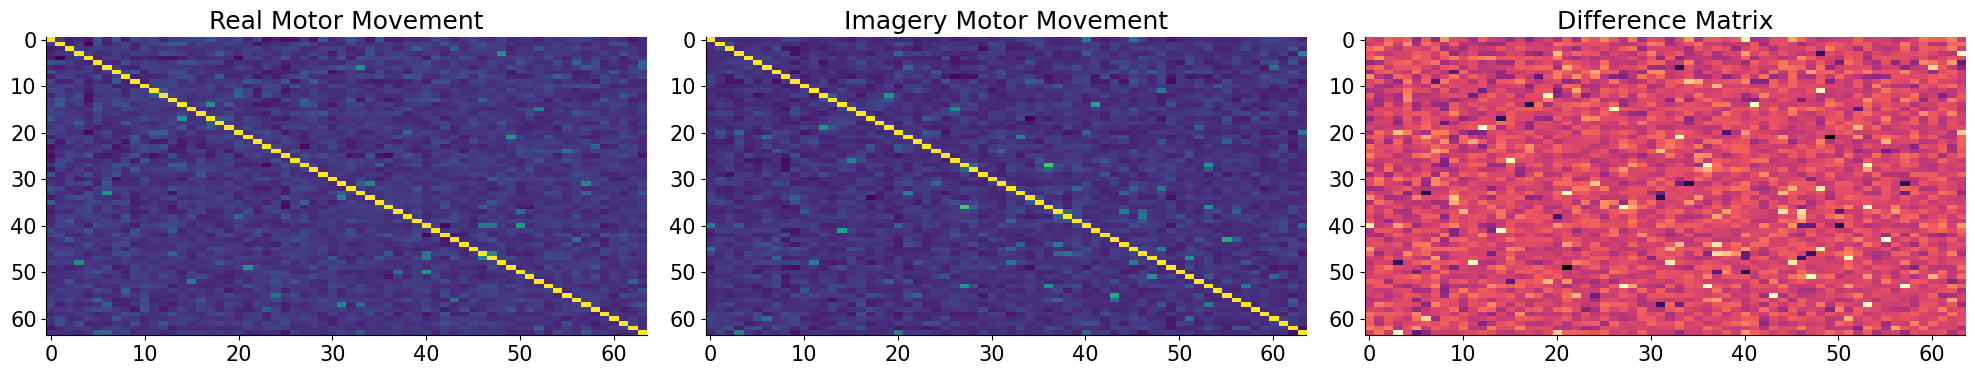

In [ ]:
corr_electrodes= range(V_r.shape[1])
randt = rand_timeseries(V_r,re,V_i,img,20)
coeff_matrix=np.array(rand_timeseries(V_r,re,V_i,img,0))
for electrode in corr_electrodes[1:]:
  new_row= rand_timeseries(V_r,re,V_i,img,electrode)
  coeff_matrix = np.vstack([coeff_matrix, new_row])

correlations1 = np.corrcoef(coeff_matrix)


coeff_matrix=np.array(rand_timeseries(V_r,re,V_i,img,0))
for electrode in corr_electrodes[1:]:
  new_row= rand_timeseries(V_r,re,V_i,img,electrode)
  coeff_matrix = np.vstack([coeff_matrix, new_row])

correlations2 = np.corrcoef(coeff_matrix)

crr3 = correlations2-correlations1
make_confussion_graphs(correlations1,correlations2,crr3)

rr = calculate_dissimilarity(correlations1,correlations2)[0][1]
dissimilarity = 1-rr

Trying 1000 randomized trials for each subject

In [ ]:
dissimilarities_rand = list()
for i in range(7):
  dissimilarities_rand.append([])
  V_r,re,_ = pick_subj_exp(i,"real_mov")
  V_i,img,_ = pick_subj_exp(i,"imagery")
  for j in range(1000):
    if j%200 == 0:
      print("subject",i , "," ,j,"th epoch")

    corr_electrodes= range(V_r.shape[1])

    coeff_matrix=np.array(rand_timeseries(V_r,re,V_i,img,0))
    for electrode in corr_electrodes[1:]:
      new_row= rand_timeseries(V_r,re,V_i,img,electrode)
      coeff_matrix = np.vstack([coeff_matrix, new_row])

    correlations1 = np.corrcoef(coeff_matrix)


    coeff_matrix=np.array(rand_timeseries(V_r,re,V_i,img,0))
    for electrode in corr_electrodes[1:]:
      new_row= rand_timeseries(V_r,re,V_i,img,electrode)    #takes too much time put it outside the inner for loop
      coeff_matrix = np.vstack([coeff_matrix, new_row])

    correlations2 = np.corrcoef(coeff_matrix)

    crr3 = correlations2-correlations1

    rr = calculate_dissimilarity(correlations1,correlations2)[0][1]
    dissimilarity = 1-rr

    #average of 6 participants
    dissimilarities_rand[i].append(dissimilarity)


subject 0 , 0 th epoch
subject 0 , 200 th epoch
subject 0 , 400 th epoch
subject 0 , 600 th epoch
subject 0 , 800 th epoch
subject 1 , 0 th epoch
subject 1 , 200 th epoch
subject 1 , 400 th epoch
subject 1 , 600 th epoch
subject 1 , 800 th epoch
subject 2 , 0 th epoch
subject 2 , 200 th epoch
subject 2 , 400 th epoch
subject 2 , 600 th epoch
subject 2 , 800 th epoch
subject 3 , 0 th epoch
subject 3 , 200 th epoch
subject 3 , 400 th epoch
subject 3 , 600 th epoch
subject 3 , 800 th epoch
subject 4 , 0 th epoch
subject 4 , 200 th epoch
subject 4 , 400 th epoch
subject 4 , 600 th epoch
subject 4 , 800 th epoch
subject 5 , 0 th epoch
subject 5 , 200 th epoch
subject 5 , 400 th epoch
subject 5 , 600 th epoch
subject 5 , 800 th epoch
subject 6 , 0 th epoch
subject 6 , 200 th epoch
subject 6 , 400 th epoch
subject 6 , 600 th epoch
subject 6 , 800 th epoch


In [ ]:
len(dissimilarities_rand[5])

1000

In [ ]:
dissimilarities_rand_np = np.array(dissimilarities_rand)

In [ ]:
dissimilarities_rand_np.shape

(7, 1000)

Here is the distributions of randomized data's dissimilarity distribution.

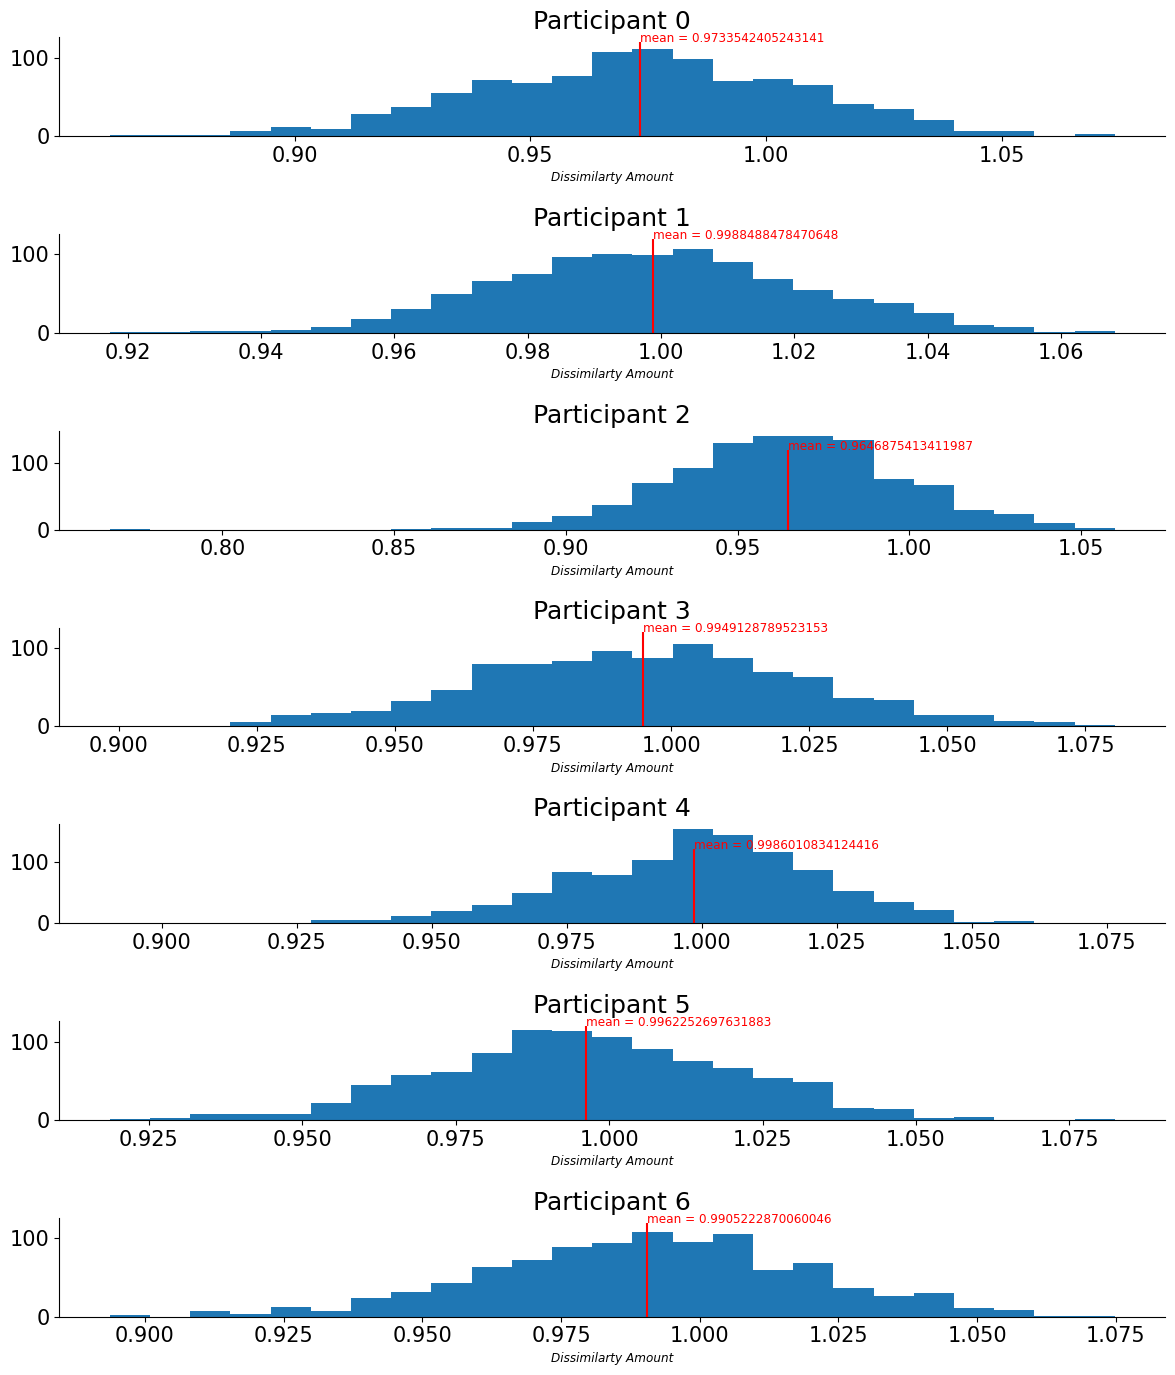

In [ ]:
plt.figure(figsize=(12,14))
for i in range(dissimilarities_rand_np.shape[0]):
  ax = plt.subplot(7, 1, i+1)
  plt.hist(dissimilarities_rand_np[i],bins=25)
  plt.vlines(dissimilarities_rand_np[i].mean(),0,120,colors ='r',label= 'mean')
  plt.title('Participant %d'%i)
  plt.text(dissimilarities_rand_np[i].mean(),120,f'mean = {dissimilarities_rand_np[i].mean()}',fontsize='xx-small',color ='r')
  plt.xlabel('Dissimilarty Amount', fontsize= 'xx-small', fontstyle='italic')
plt.show()

In [ ]:
means_rand = list()
for i in range(7):
  means_rand.append(dissimilarities_rand_np[i].mean())

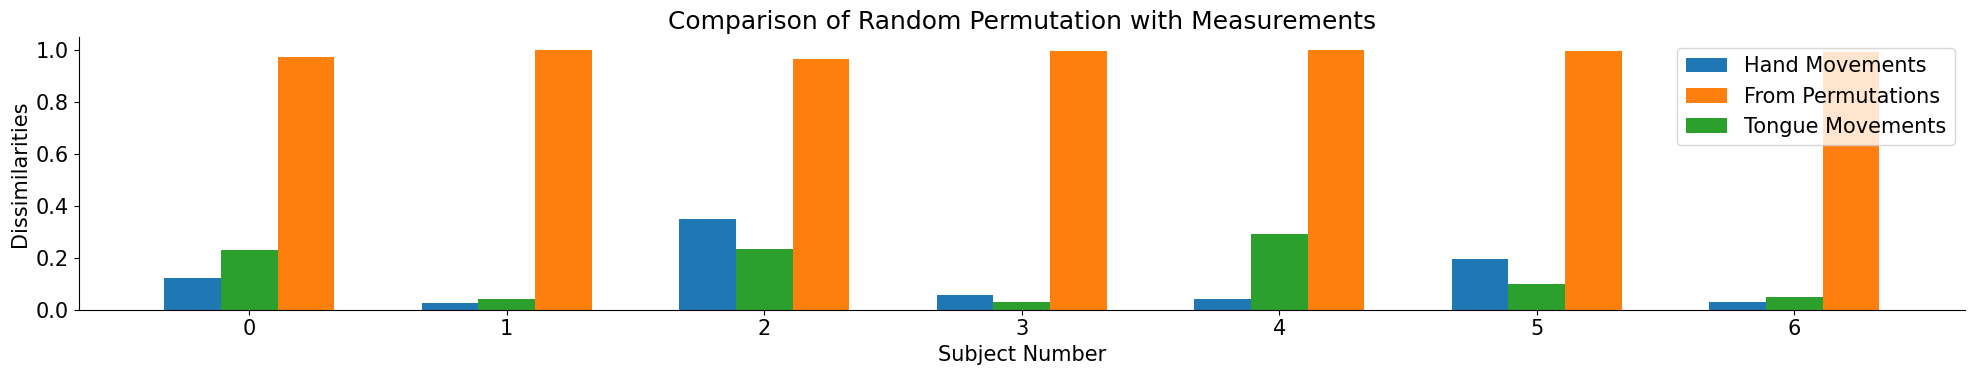

In [ ]:


bar_width = 0.22

x_indices = range(7)

# Create the bar chart
plt.bar(x_indices, dissimilarities_hand, width=bar_width, label='Hand Movements')
plt.bar([i + 2*bar_width for i in x_indices], means_rand, width=bar_width, label='From Permutations')
plt.bar([i + bar_width for i in x_indices], dissimilarities_tongue, width=bar_width, label='Tongue Movements')


plt.xlabel('Subject Number')
plt.ylabel('Dissimilarities')
plt.title('Comparison of Random Permutation with Measurements')
plt.xticks([i + bar_width for i in x_indices], categories)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
len(dissimilarities_tongue)

7

In [ ]:
print(dissimilarities_tongue[5])


0.09793071621482385


In [ ]:
import pandas as pd
rand_df = pd.DataFrame(dissimilarities_rand_np)
rand_df.to_csv('output.csv', encoding = 'utf-8-sig')
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>